# 案例
## 1.自回归


                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Wed, 23 Nov 2022   AIC                           5996.884
Time:                        19:30:27   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

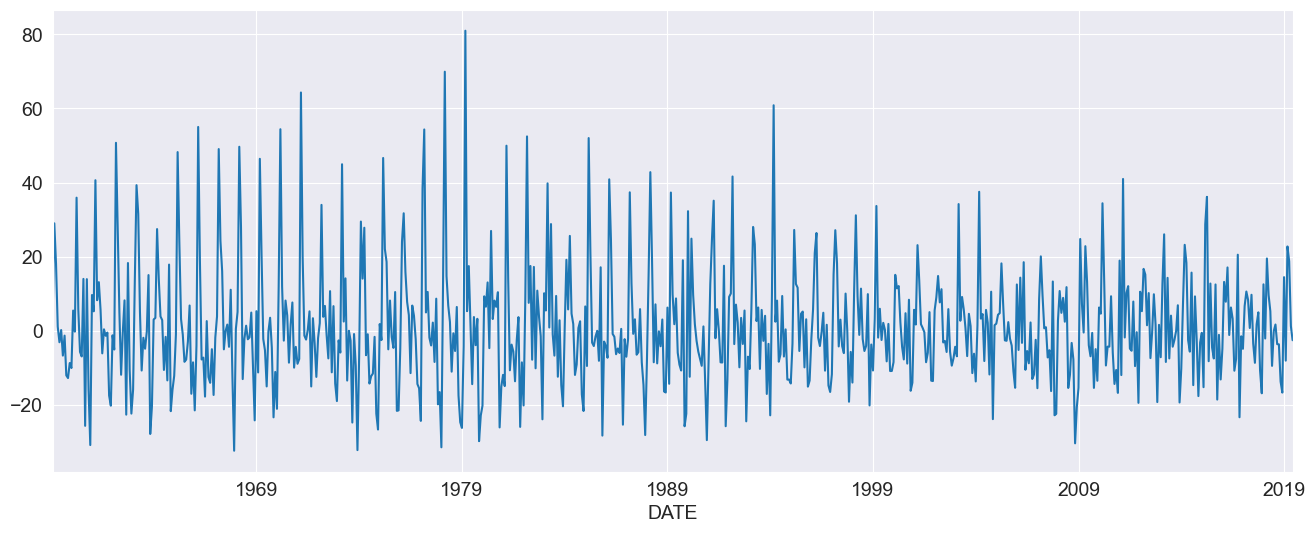

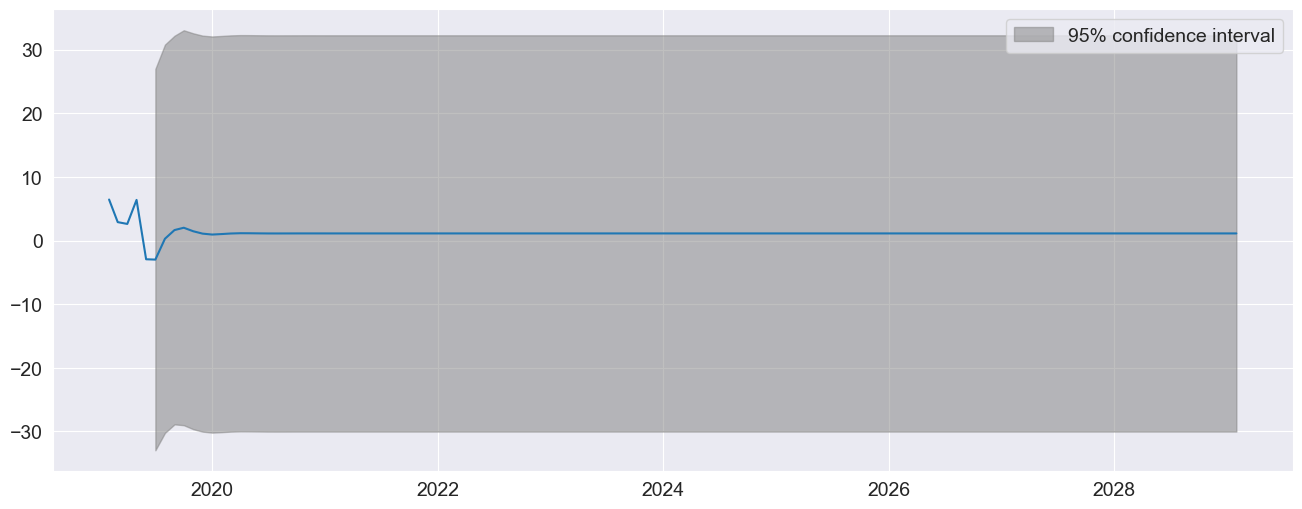

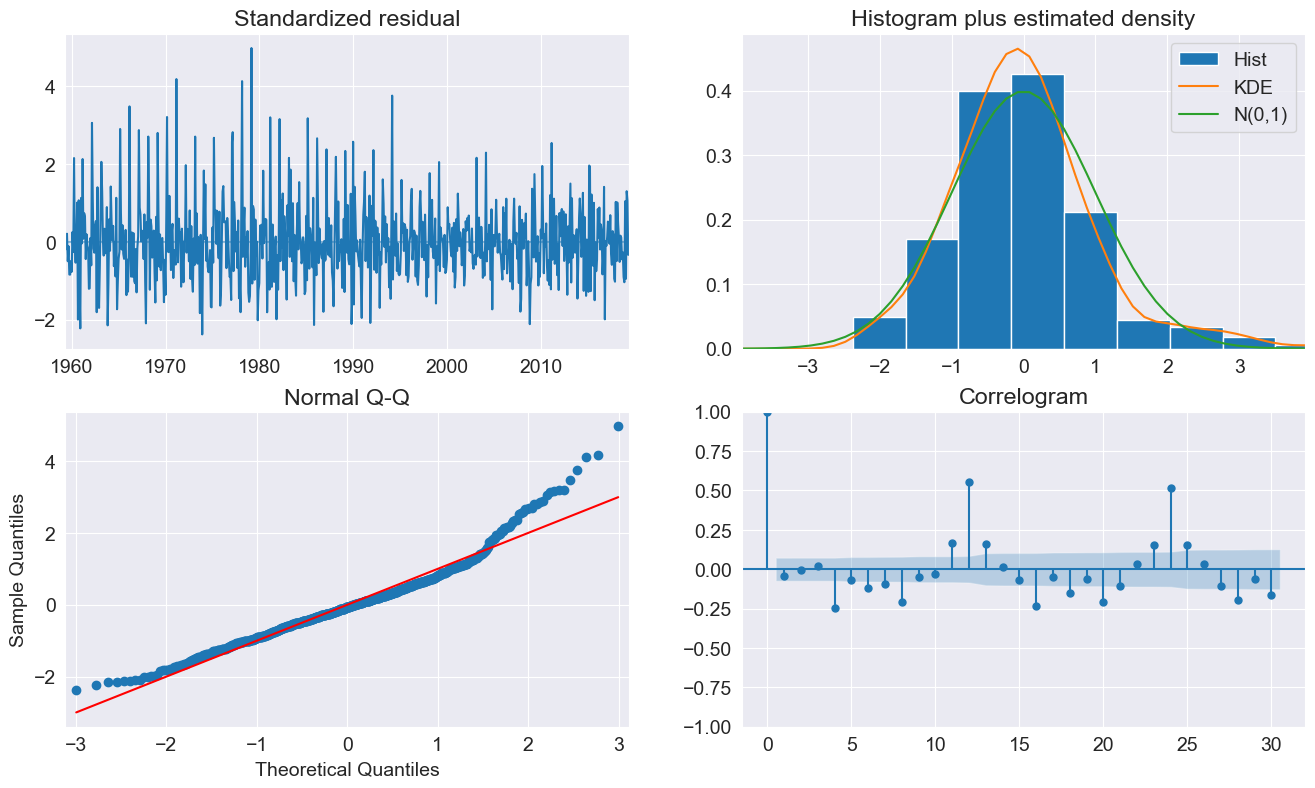

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
assert isinstance(ax, object)
ax = housing.plot(ax=ax)

mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

fig = res.plot_predict(720, 840)

fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

plt.show()


## 2.季节动态

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  714
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 590.875
Method:                     Conditional MLE   S.D. of innovations              0.104
Date:                      Wed, 23 Nov 2022   AIC                          -1143.751
Time:                              19:32:30   BIC                          -1057.253
Sample:                          02-01-1961   HQIC                         -1110.317
                               - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0167      0.014      1.215      0.224      -0.010       0.044
s(2,12)         -0.0179      0.019     -0.931      0.352      -0.056       0.

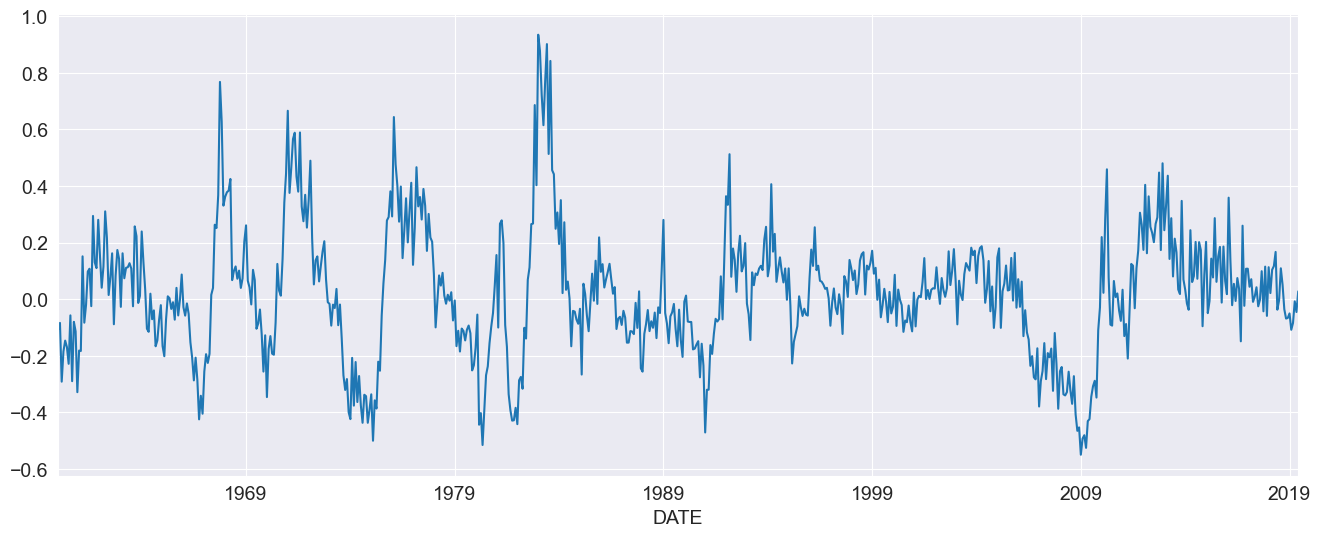

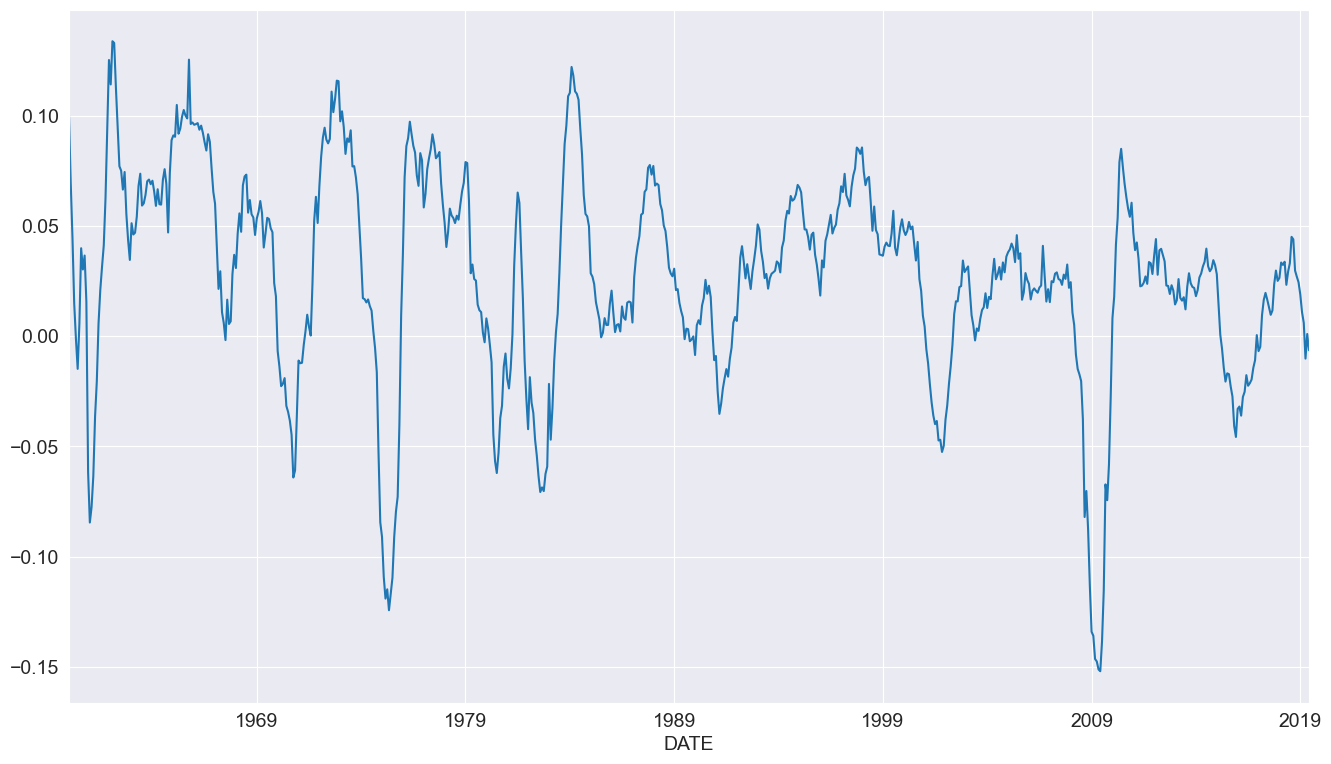

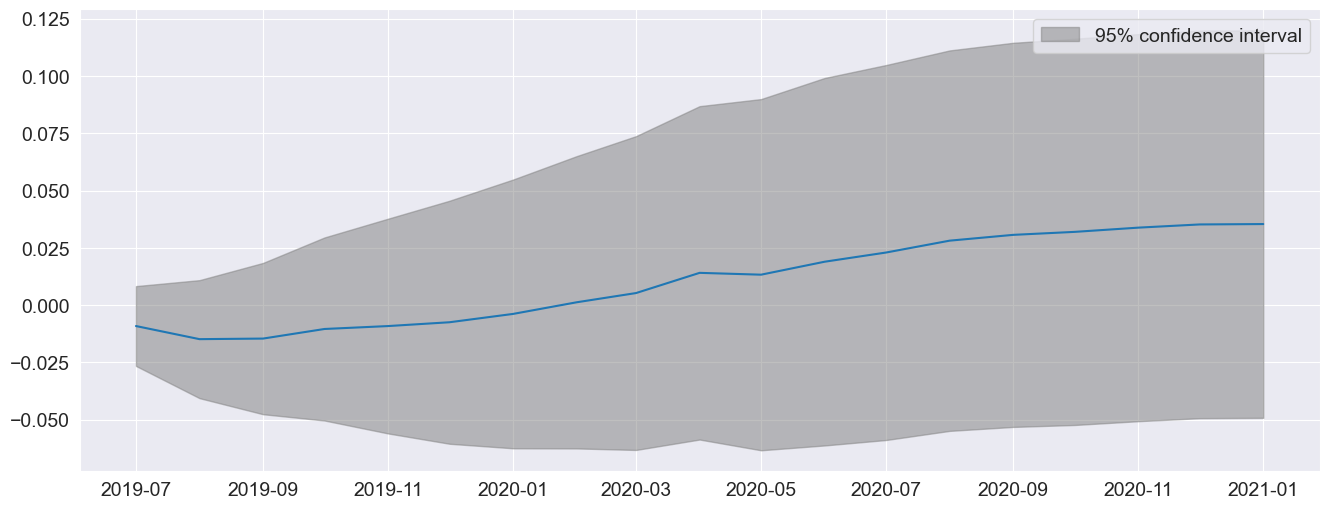

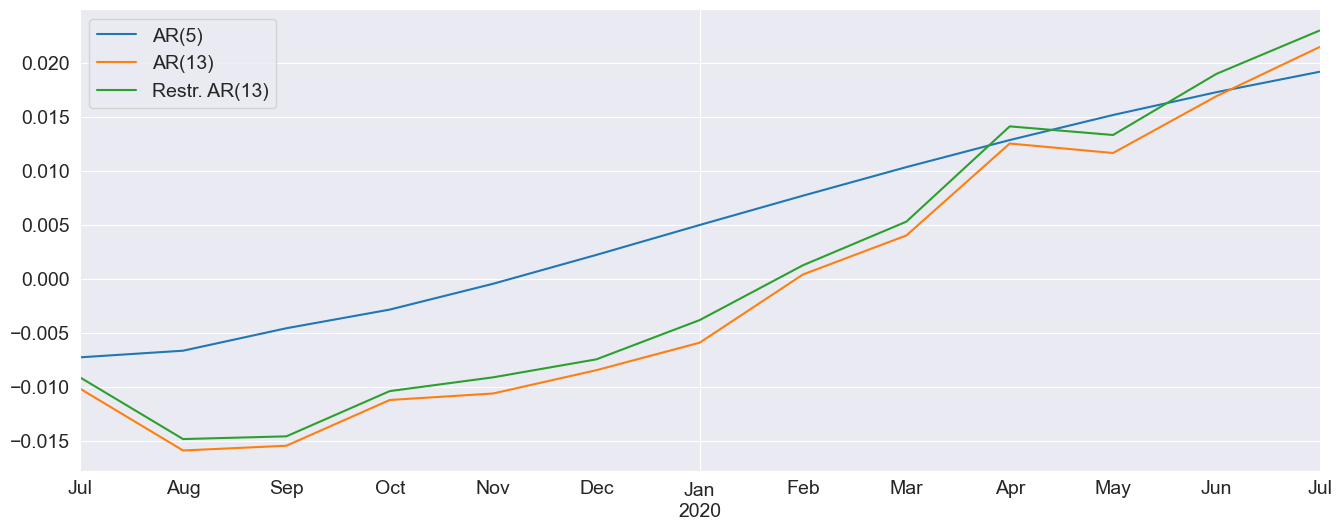

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")

yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags


sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

data = pdr.get_data_fred("INDPRO", "1959-01-01", "2019-06-01")
ind_prod = data.INDPRO.pct_change(12).dropna().asfreq("MS")
_, ax = plt.subplots(figsize=(16, 9))
ind_prod.plot(ax=ax)

sel = ar_select_order(ind_prod, 13, "bic", old_names=False)
res = sel.model.fit()
print(res.summary())


sel = ar_select_order(ind_prod, 13, "bic", glob=True, old_names=False)
sel.ar_lags
res_glob = sel.model.fit()
print(res.summary())

ind_prod.shape



fig = res_glob.plot_predict(start=714, end=732)

res_ar5 = AutoReg(ind_prod, 5, old_names=False).fit()
predictions = pd.DataFrame(
    {
        "AR(5)": res_ar5.predict(start=714, end=726),
        "AR(13)": res.predict(start=714, end=726),
        "Restr. AR(13)": res_glob.predict(start=714, end=726),
    }
)
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

plt.show()


# 案例3 课余

In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy.linalg as la
import math
# from statsmodels.tsa.arima_model import ARIMA
import time
import statsmodels.api as sm

def preprocess_data(data, time_len, rate, seq_len, pre_len):
    data1 = np.mat(data)
    train_size = int(time_len * rate)
    train_data = data1[0:train_size]
    test_data = data1[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0: seq_len])
        trainY.append(a[seq_len: seq_len + pre_len])
    for i in range(len(test_data) - seq_len - pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0: seq_len])
        testY.append(b[seq_len: seq_len + pre_len])
    return trainX, trainY, testX, testY


###### evaluation ######
def evaluation(a, b):
    rmse = math.sqrt(mean_squared_error(a, b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a - b) / la.norm(a)
    r2 = 1 - ((a - b) ** 2).sum() / ((a - a.mean()) ** 2).sum()
    var = 1 - (np.var(a - b)) / np.var(a)
    return rmse, mae, 1 - F_norm, r2, var


time_start = time.time()
path = r'./432_1800_cql_00001.csv'
data = pd.read_csv(path,encoding='utf-8')

time_len = data.shape[0]
num_nodes = data.shape[1]
train_rate = 0.8
seq_len = 7
pre_len = 1
trainX, trainY, testX, testY = preprocess_data(data, time_len, train_rate, seq_len, pre_len)
method = 'ARIMA'  ####HA or SVR or ARIMA

######## ARIMA #########
if method == 'ARIMA':
    rng = pd.date_range('1/3/2012', periods=1379, freq='D')
    a1 = pd.DatetimeIndex(rng)
    data.index = a1
    num = data.shape[1]
    rmse, mae, acc, r2, var, pred, ori = [], [], [], [], [], [], []
    for i in range(3):
        ts = data.iloc[:, i]
        ts_log = np.log(ts)
        ts_log = ts
        ts_log = np.array(ts_log, dtype=np.float)
        where_are_inf = np.isinf(ts_log)
        ts_log[where_are_inf] = 0
        ts_log = pd.Series(ts_log)
        ts_log.index = a1
        model = sm.tsa.arima.ARIMA(ts_log, order=(1, 1, 1))
        # model = ARIMA(ts_log, order=[1, 0, 0])
        properModel = model.fit()
        predict_ts = properModel.predict(4, dynamic=True)
        log_recover = np.exp(predict_ts)
        log_recover = predict_ts
        ts = ts[log_recover.index]
        path = './output/'
        name = 'logrecover_' + str(i) + '.csv'
        logrecover = pd.DataFrame(log_recover)
        logrecover.to_csv(path + name)
        er_rmse, er_mae, er_acc, r2_score, var_score = evaluation(ts, log_recover)
        rmse.append(er_rmse)
        mae.append(er_mae)
        acc.append(er_acc)
        r2.append(r2_score)
        var.append(var_score)
    #    for i in range(109,num):
    #        ts = data.iloc[:,i]
    #        ts_log=np.log(ts)
    #        ts_log=np.array(ts_log,dtype=np.float)
    #        where_are_inf = np.isinf(ts_log)
    #        ts_log[where_are_inf] = 0
    #        ts_log = pd.Series(ts_log)
    #        ts_log.index = a1
    #        model = ARIMA(ts_log,order=[1,1,1])
    #        properModel = model.fit(disp=-1, method='css')
    #        predict_ts = properModel.predict(2, dynamic=True)
    #        log_recover = np.exp(predict_ts)
    #        ts = ts[log_recover.index]
    #        er_rmse,er_mae,er_acc,r2_score,var_score = evaluation(ts,log_recover)
    #        rmse.append(er_rmse)
    #        mae.append(er_mae)
    #        acc.append(er_acc)
    #        r2.append(r2_score)
    #        var.append(var_score)
    acc1 = np.mat(acc)
    acc1[acc1 < 0] = 0
    print('arima_rmse:%r' % (np.mean(rmse)),
          'arima_mae:%r' % (np.mean(mae)),
          'arima_acc:%r' % (np.mean(acc1)),
          'arima_r2:%r' % (np.mean(r2)),
          'arima_var:%r' % (np.mean(var)))

time_end = time.time()
print(time_end - time_start, 's')


FileNotFoundError: [Errno 2] No such file or directory: './432_1800_cql_00001.csv'